In [8]:
!pip3 install wolframclient.evaluation, wolframclient.language

557.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this error.
    
    If you disable this

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun  7 16:17:46 2024

@author: User

1a: There is only 1 value in each alphas.
"""

from CFT_lego import CFT_lego
import cvxpy as cp
import numpy as np
from DG_analytic_v2 import DG
from Where_execute import Where_execute

root_dir = Where_execute()
cft = CFT_lego()

class LP:
    def __init__(self, low_delta_list, delta_truncation, delta_spacing, delta_max, 
                 rescale_factor, how_many_constraints,data):
        self.low_delta_list = low_delta_list
        self.delta_truncation = delta_truncation
        self.delta_spacing = delta_spacing
        self.delta_max = delta_max
        self.rescale_factor = rescale_factor
        
        self.num_grid = int((delta_max-max(low_delta_list))/ delta_spacing)
        self.delta_list = low_delta_list+[delta_truncation+delta_spacing*i for i in range(1, self.num_grid+2)]
        
        dn_constraints = [2*i+1 for i in range(how_many_constraints)]
        
        self.derivative_constraints = DG(data, self.delta_list, 2, how_many_constraints)*np.exp(-rescale_factor*np.array(self.delta_list))
        self.solver = np.array([2]+[0 for _ in range(how_many_constraints-1)])
        
        self.a1_eq = np.array(list(DG(data, self.low_delta_list, 2, 1)[0]*np.exp(-rescale_factor*np.array(self.low_delta_list))) + 
                              [0 for _ in range(1, self.num_grid+2)])
    
    def a1_bound(self):
        # Define and solve the CVXPY problem.
        ope = cp.Variable(len(self.delta_list))
        prob_low = cp.Problem(cp.Minimize(self.a1_eq@ope-2),
                               [self.derivative_constraints @ ope == self.solver, 
                                # ope[:len(self.low_delta_list)]>=1e-5,
                                ope>=0])
        
        prob_up = cp.Problem(cp.Maximize(self.a1_eq@ope-2),
                               [self.derivative_constraints @ ope == self.solver, 
                                # ope[:len(self.low_delta_list)]>=1e-5,
                                ope>=0])
        
        try:
            prob_low.solve()
            prob_up.solve()
            if type(prob_low.value) == np.float64 and type(prob_up.value) == np.float64:
                return [prob_low.value, prob_up.value]
            else:
               # print('Inf bound: ', [prob_low.value, prob_up.value])
                return None
        except:
           # print('No bound')
            return None
    
    def alpha_criteria(self):
        a1_range = self.a1_bound()
        if a1_range == None:
            return 'No such bound'
        else:
            return 'Exist bound', a1_range

class LP_data:
    def __init__(self, low_delta_list, delta_truncation, delta_spacing, delta_max, rescale_factor):
        self.low_delta_list = low_delta_list
        self.delta_truncation = delta_truncation
        self.delta_spacing = delta_spacing
        self.delta_max = delta_max
        self.rescale_factor = rescale_factor
    
    def stored_a_bound(self, how_many_constraints):
        import os
        import json
        file_name = f'LP_data/a_region_constraint_num{how_many_constraints}_with_alphabound.json'
        
        d_property = {'delta':self.low_delta_list, 'd_truncate':self.delta_truncation, 
                      'd_space':self.delta_spacing, 'd_max':self.delta_max, 'd_rf':self.rescale_factor}
        
        if os.path.isfile(root_dir+file_name):
            with open(os.path.join(root_dir, file_name), 'r') as file:
                combined_data = json.load(file)
            # 将 target_label 转换为 JSON 字符串
            target_label_str = json.dumps(d_property)
            
            # 获取对应的值
            values = combined_data.get(target_label_str)
            
            if values is None:
                print('Building new alpha json element!')
                lp = LP(self.low_delta_list, self.delta_truncation, 
                        self.delta_spacing, self.delta_max, self.rescale_factor, how_many_constraints)
                a_bound = lp.alpha_criteria()
                alpha_container = {'property':a_bound[0], 'alpha bound': a_bound[1]}
                # 创建以 d_property 标签为键的字典，值为 alpha_container
                combined_data[json.dumps(d_property)] = alpha_container
                
                # Write to JSON file
                with open(os.path.join(root_dir, file_name), 'w') as file:
                    json.dump(combined_data, file, indent=4)
                
                return alpha_container
            else:
                return values
        else:
            print('Building new alpha json file!')
            combined_data={}
            lp = LP(self.low_delta_list, self.delta_truncation, 
                    self.delta_spacing, self.delta_max, self.rescale_factor, how_many_constraints)
            a_bound = lp.alpha_criteria()
            alpha_container = {'property':a_bound[0], 'alpha bound': a_bound[1]}
            # 创建以 d_property 标签为键的字典，值为 alpha_container
            combined_data[json.dumps(d_property)] = alpha_container
            
            # Write to JSON file
            with open(os.path.join(root_dir, file_name), 'w') as file:
                json.dump(combined_data, file, indent=4)
            return alpha_container

In [12]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from get_allowed_2states import get_allowed_2states
import random

# Define the custom environment
class LpEnv(gym.Env):
    def __init__(self,deltas_1_2,data,max_action=5.,delta_spacing=0.1,delta_max=50,penalty_not_allowed=5.,step_cost=.1,nder=5,max_steps=20,rew=1,delta_tol=.1):
        super(LpEnv, self).__init__()
        self.observation_space = spaces.Box(low=2, high=100, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Box(low=-max_action, high=max_action, shape=(1,), dtype=np.float32)
        self.delta_spacing=delta_spacing
        self.delta_max=delta_max
        self.deltas_1_2=deltas_1_2
        [delta1,delta2]=self.random_deltas()
        self.state =np.array([delta1,delta2,delta2],dtype=np.float32)
        self.penalty_not_allowed=penalty_not_allowed
        self.step_cost=step_cost
        self.nder=nder
        
        self.max_steps=max_steps
        self.current_step=0
        self.reward =rew
        self.data=data
        self.delta_tol=delta_tol
        self.lp =LP( self.state.tolist(), self.state[-1], self.delta_spacing, self.delta_max, 
                 0.8, self.nder,self.data)
        
        
        
    def step(self, action):
        self.current_step+=1
        self.state[2]+=action  
        if self.state[2]<self.state[1]:
            self.state[2]=self.state[1]+(self.state[1]-self.state[2])

        bounds1=self.get_lp_bound(self.state.tolist())
        bounds2=self.get_lp_bound((self.state+np.array([0,0,self.delta_tol])).tolist())

        if bounds1!=None and bounds2==None:
            reward=self.reward
            done=True
            truncated=False
        elif bounds1==None:
            reward=-self.penalty_not_allowed
            done=True
            truncated=False
        else:
            reward=-self.step_cost
            truncated = self.current_step>=self.max_steps
            done=truncated
        bounds1=np.array(bounds1)
        if(bounds1.shape!=(2,)): bounds1=np.array([0,-1])
        return np.concatenate((self.state,bounds1)), reward, done, truncated,{}
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step=0
        [delta1,delta2]=self.random_deltas() if options==None  else [options["delta1"],options["delta2"]]
        self.state =np.array([delta1,delta2,delta2],dtype=np.float32)
        bounds1=self.get_lp_bound(self.state.tolist())
        bounds1=np.array(bounds1)
        if(bounds1.shape!=(2,)): bounds1=np.array([0,-1])
        return np.concatenate((self.state,bounds1),dtype=np.float32),{}
    
    def random_deltas(self):
        return random.choice(self.deltas_1_2)
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass
    
    def get_lp_bound(self, state):
        self.lp.low_delta_list= state
        self.lp.delta_truncation=state[-1]
        
       
        

        return self.lp.a1_bound()

In [4]:
def get_max_delta(state,delta_spacing, delta_max,delta_tol, nder,data):
    
    bounds=0
    n=0
    while bounds!=None:
        state=(np.array(state)+np.array([0,0,delta_tol])).tolist()
        lp =LP( state, state[-1], delta_spacing, delta_max, 
                    0.8, nder,data)
        bounds=lp.a1_bound()
        n+=1

    return state[-1]-delta_tol,n

In [6]:
get_max_delta([2,4,6],.1, 60,.01, 10,data)

(6.249999999999995, 26)

In [8]:
get_max_delta([2,4,4],.1, 60,.01, 5,data)

(7.29999999999993, 331)

In [10]:
get_max_delta([3.4,6,6],.1, 50,.1, 5,data)

(7.599999999999994, 17)

In [49]:
get_max_delta([2,4,4],.1, 50,.01, 16,data)

6.209999999999953

In [46]:
get_max_delta([2,4,4],.1, 60,.01, 15,data)

6.209999999999953

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from get_allowed_2states import get_allowed_2states
import random

# Define the custom environment
class LpEnvOld(gym.Env):
    def __init__(self,deltas_1_2,data,max_action=5.,delta_spacing=0.1,delta_max=50,penalty=1000,nder=5,max_steps=100,max_rew=100):
        super(LpEnv, self).__init__()
        self.observation_space = spaces.Box(low=2, high=100, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Box(low=-max_action, high=max_action, shape=(1,), dtype=np.float32)
        self.delta_spacing=delta_spacing
        self.delta_max=delta_max
        self.state = np.random.rand(3)
        self.penalty=penalty
        self.nder=nder
        self.deltas_1_2=deltas_1_2
        self.max_steps=max_steps
        self.current_step=0
        self.max_rew =max_rew
        self.data=data
        self.reset()
        
        
    def step(self, action):
        self.current_step+=1
        self.state[2]+=action  
        if self.state[2]<self.state[1]:
            self.state[2]=self.state[1]+(self.state[1]-self.state[2])
        reward = self.get_lp_rew(self.state.tolist())

        truncated = self.current_step>=self.max_steps
        done=truncated
        if reward>self.max_rew:
            done=True
            reward=self.max_rew*100
            truncated=False
        return self.state, reward, done, truncated,{}
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step=0
        [delta1,delta2]=self.random_deltas()
        self.state =np.array([delta1,delta2,delta2],dtype=np.float32)
        return self.state,{}
    
    def random_deltas(self):
        return random.choice(self.deltas_1_2)
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass
    
    def get_lp_rew(self, state):
        
        lp =LP( state, state[-1], self.delta_spacing, self.delta_max, 
                 0.8, self.nder,self.data)
        bound=lp.a1_bound()
        if bound == None:
            return -self.penalty*state[-1]

        return 1./np.dot(lp.a1_bound(),[-1,1])

In [5]:
data.iloc[:3]

,derivative order,1,1.01,1.02,1.1,1.2,1.3,1.4,1.5,1.6,...,99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99,100
0,1,-0.386294,-0.375024,-0.363834,-0.277110,-0.175469,-0.080964,0.006795,0.088178,0.163536,...,6.550000e-15,6.520000e-15,6.500000e-15,6.480000e-15,6.450000e-15,6.430000e-15,6.410000e-15,6.380000e-15,6.360000e-15,6.340000e-15
1,3,1.333333,1.299227,1.264787,0.978789,0.601867,0.213468,-0.176866,-0.560834,-0.931266,...,8.380000e-11,8.350000e-11,8.320000e-11,8.290000e-11,8.270000e-11,8.240000e-11,8.210000e-11,8.180000e-11,8.150000e-11,8.120000e-11
2,5,0.533333,0.516731,0.500854,0.399917,0.337079,0.337798,0.390701,0.481446,0.593898,...,3.170000e-07,3.160000e-07,3.150000e-07,3.140000e-07,3.130000e-07,3.120000e-07,3.110000e-07,3.100000e-07,3.090000e-07,3.080000e-07


In [6]:
DG(data, training_deltas[1], 3, 3)

[[0.651729627, 0.763364084],
 [-2.94347937, -2.463340915],
 [-0.391903385, -3.838034791]]

In [139]:
root_dir

'/Users/justinas/Documents/python/lp ml/'

In [8]:
arr

[[1.0, 2.7],
 [1.0, 2.8],
 [1.0, 2.9],
 [1.0, 3.0],
 [1.0, 3.1],
 [1.1, 2.7],
 [1.1, 2.8],
 [1.1, 2.9],
 [1.1, 3.0],
 [1.1, 3.1],
 [1.2, 2.8],
 [1.2, 2.9],
 [1.2, 3.0],
 [1.2, 3.1],
 [1.3, 3.0],
 [1.3, 3.1],
 [1.4, 1.4],
 [1.4, 1.5],
 [1.4, 1.6],
 [1.4, 1.7],
 [1.4, 1.8],
 [1.4, 1.9],
 [1.4, 2.0],
 [1.4, 2.1],
 [1.4, 2.2],
 [1.4, 2.3],
 [1.4, 2.4],
 [1.4, 2.5],
 [1.4, 2.6],
 [1.4, 2.7],
 [1.4, 2.8],
 [1.4, 2.9],
 [1.4, 3.0],
 [1.4, 3.1],
 [1.4, 3.2],
 [1.4, 3.3],
 [1.4, 3.4],
 [1.4, 3.5],
 [1.4, 3.6],
 [1.4, 3.7],
 [1.4, 3.8],
 [1.4, 3.9],
 [1.4, 4.0],
 [1.4, 4.1],
 [1.5, 1.5],
 [1.5, 1.6],
 [1.5, 1.7],
 [1.5, 1.8],
 [1.5, 1.9],
 [1.5, 2.0],
 [1.5, 2.1],
 [1.5, 2.2],
 [1.5, 2.3],
 [1.5, 2.4],
 [1.5, 2.5],
 [1.5, 2.6],
 [1.5, 2.7],
 [1.5, 2.8],
 [1.5, 2.9],
 [1.5, 3.0],
 [1.5, 3.1],
 [1.5, 3.2],
 [1.5, 3.3],
 [1.5, 3.4],
 [1.5, 3.5],
 [1.5, 3.6],
 [1.5, 3.7],
 [1.5, 3.8],
 [1.5, 3.9],
 [1.5, 4.0],
 [1.5, 4.1],
 [1.5, 4.2],
 [1.6, 1.6],
 [1.6, 1.7],
 [1.6, 1.8],
 [1.6, 1.9],
 [1.6, 2.0],

In [5]:
from get_allowed_2states import get_allowed_2states

import random
import pandas as pd

path = root_dir+"LP_data/isingDGn_v5.csv"
data = pd.read_csv(path)

arr=get_allowed_2states()

In [ ]:
(self,deltas_1_2,data,max_action=.5,delta_spacing=0.1,delta_max=50,penalty=.1,nder=5,max_steps=100,rew=1,delta_tol=.1)

In [34]:
env = LpEnv([[2,4]],data)

In [149]:
env.step(-.2)

(array([ 2.00000000e+00,  4.00000000e+00,  7.10000038e+00, -8.57041837e-02,
        -3.24692767e-05]),
 -0.1,
 False,
 False,
 {})

In [6]:
filtered_data = [item for item in arr if item[1] > 2]

print("Filtered data:", filtered_data)

Filtered data: [[1.0, 2.7], [1.0, 2.8], [1.0, 2.9], [1.0, 3.0], [1.0, 3.1], [1.1, 2.7], [1.1, 2.8], [1.1, 2.9], [1.1, 3.0], [1.1, 3.1], [1.2, 2.8], [1.2, 2.9], [1.2, 3.0], [1.2, 3.1], [1.3, 3.0], [1.3, 3.1], [1.4, 2.1], [1.4, 2.2], [1.4, 2.3], [1.4, 2.4], [1.4, 2.5], [1.4, 2.6], [1.4, 2.7], [1.4, 2.8], [1.4, 2.9], [1.4, 3.0], [1.4, 3.1], [1.4, 3.2], [1.4, 3.3], [1.4, 3.4], [1.4, 3.5], [1.4, 3.6], [1.4, 3.7], [1.4, 3.8], [1.4, 3.9], [1.4, 4.0], [1.4, 4.1], [1.5, 2.1], [1.5, 2.2], [1.5, 2.3], [1.5, 2.4], [1.5, 2.5], [1.5, 2.6], [1.5, 2.7], [1.5, 2.8], [1.5, 2.9], [1.5, 3.0], [1.5, 3.1], [1.5, 3.2], [1.5, 3.3], [1.5, 3.4], [1.5, 3.5], [1.5, 3.6], [1.5, 3.7], [1.5, 3.8], [1.5, 3.9], [1.5, 4.0], [1.5, 4.1], [1.5, 4.2], [1.6, 2.1], [1.6, 2.2], [1.6, 2.3], [1.6, 2.4], [1.6, 2.5], [1.6, 2.6], [1.6, 2.7], [1.6, 2.8], [1.6, 2.9], [1.6, 3.0], [1.6, 3.1], [1.6, 3.2], [1.6, 3.3], [1.6, 3.4], [1.6, 3.5], [1.6, 3.6], [1.6, 3.7], [1.6, 3.8], [1.6, 3.9], [1.6, 4.0], [1.6, 4.1], [1.6, 4.2], [1.6, 4.3], 

In [26]:
# Find the index of the list with the minimum value in the second column
min_index = min(range(len(training_deltas)), key=lambda i: training_deltas[i][1])

print("Index of the minimum value in the second column:", min_index)
print("Row with the minimum value in the second column:", training_deltas[min_index])


Index of the minimum value in the second column: 166
Row with the minimum value in the second column: [1.4, 1.5]


In [22]:
training_deltas=random.sample(arr, 200)

In [8]:
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

class RewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        if done := self.locals["dones"]:
            self.episode_rewards.append(self.locals["rewards"][0])
        return True



In [ ]:
(max_action=5.,delta_spacing=0.1,delta_max=50,penalty_not_allowed=1.,step_cost=.1,nder=5,max_steps=20,rew=1,delta_tol=.1)

In [21]:
validation_deltas=[item for item in filtered_data if item not in training_deltas]

In [31]:
env = LpEnv(training_deltas,data,max_action=5.,delta_spacing=0.1,delta_max=50,penalty_not_allowed=1.,step_cost=.1,nder=5,max_steps=20,rew=1,delta_tol=.1)


ValueError: operands could not be broadcast together with shapes (3,) (468,) 

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | -2       |
| time/              |          |
|    fps             | 7        |
|    iterations      | 1        |
|    time_elapsed    | 267      |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 20         |
|    ep_rew_mean          | -2         |
| time/                   |            |
|    fps                  | 7          |
|    iterations           | 2          |
|    time_elapsed         | 536        |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00695704 |
|    clip_fraction        | 0.0503     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.41      |
|    explained_variance   | 0.194      |
|    learning_rate        | 

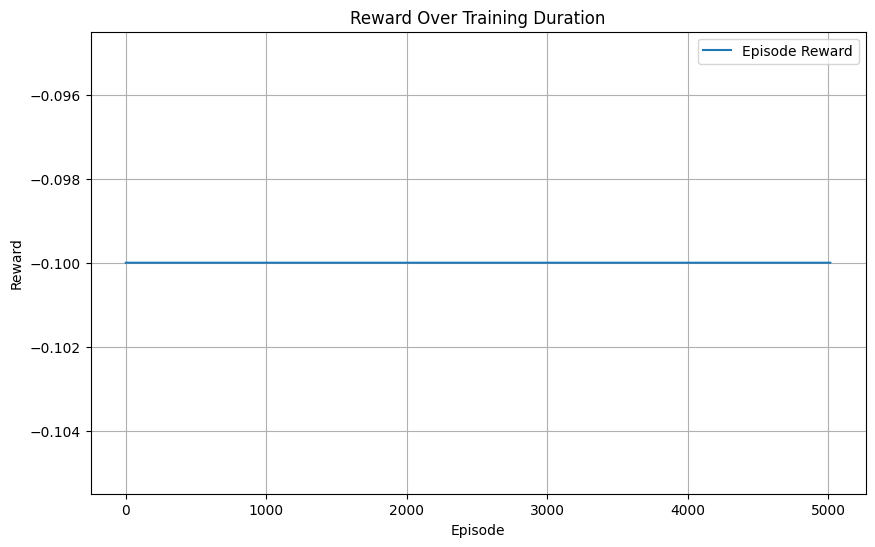

In [43]:
training_deltas=random.sample(filtered_data, 200)

env = LpEnv(training_deltas,data,max_action=5.,delta_spacing=0.1,delta_max=50,penalty_not_allowed=1.,step_cost=.1,nder=5,max_steps=20,rew=1,delta_tol=.1)


# Check if the environment follows the Gym API
#check_env(env, warn=True)

# Create a vectorized environment
vec_env = make_vec_env(lambda: LpEnv(training_deltas,data,max_action=5.,delta_spacing=0.1,delta_max=50,penalty_not_allowed=1.,step_cost=.1,nder=5,max_steps=20,rew=1,delta_tol=.1), n_envs=1)

# Choose the algorithm: PPO or SAC
model = PPO('MlpPolicy', vec_env, verbose=1)
reward_callback = RewardCallback()
# Train the model
model.learn(total_timesteps=100000, callback=reward_callback)

# Save the model
model.save("ppo_100k_steps")

# Load the model
model = PPO.load("ppo_100k_steps")

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(reward_callback.episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Over Training Duration')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
obs = vec_env.reset()


In [42]:
obs[0,2]

4.0

In [ ]:
self.state, reward, done, truncated,{}

In [137]:
vec_env.step(action)

(array([[3.1, 3.1, 3.1]], dtype=float32),
 array([1.1656426], dtype=float32),
 array([False]),
 [{'TimeLimit.truncated': False}])

In [144]:
obs

array([[1.9, 2.4, 2.4]], dtype=float32)

In [35]:
model = PPO.load("ppo_custom_env")

In [78]:
{
    'delta1': 2,
    'delta2': 4
}["delta1"]

2

In [37]:
import matplotlib.pyplot as plt


validation_rewards = []
delta=[]


In [42]:



validation_rewards = []
delta=[]
env = LpEnv(training_deltas,data)
obs,_ = env.reset(options={
    'delta1': 2,
    'delta2': 4
})
#obs,_ = env.reset()
print(obs)
for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones,_,_ = env.step(action)
    validation_rewards.append(rewards)
    delta.append(obs[2])
    if dones:
        print(i)
        print(delta[-2])
        break

[ 2.          4.          4.         -0.8560353  -0.04813831]
19
7.400424957275391


In [122]:
training_deltas

[[2.4, 2.7],
 [1.9, 2.3],
 [1.5, 4.0],
 [2.8, 3.6],
 [2.5, 3.8],
 [1.6, 3.6],
 [2.2, 2.4],
 [2.9, 3.1],
 [2.7, 4.5],
 [3.0, 3.7],
 [2.8, 3.2],
 [2.3, 2.5],
 [1.4, 2.4],
 [1.3, 3.0],
 [3.0, 4.0],
 [2.9, 3.9],
 [1.9, 3.5],
 [2.4, 3.6],
 [3.0, 3.3],
 [1.7, 3.7],
 [2.9, 3.5],
 [2.3, 4.0],
 [2.9, 3.4],
 [1.7, 2.2],
 [2.7, 4.6],
 [3.0, 3.4],
 [1.7, 2.4],
 [1.4, 2.7],
 [2.6, 4.5],
 [2.9, 3.8],
 [2.3, 3.2],
 [1.0, 3.1],
 [2.1, 3.8],
 [2.9, 4.6],
 [2.6, 4.4],
 [2.7, 2.9],
 [3.0, 4.7],
 [1.8, 3.4],
 [1.9, 4.2],
 [2.1, 3.3],
 [2.0, 3.5],
 [2.2, 3.9],
 [1.5, 3.2],
 [1.6, 2.4],
 [2.5, 4.1],
 [2.4, 3.1],
 [1.1, 2.9],
 [3.0, 4.3],
 [1.5, 2.5],
 [2.5, 3.9],
 [2.0, 2.9],
 [1.1, 3.0],
 [3.1, 4.5],
 [1.8, 3.2],
 [2.5, 3.4],
 [2.8, 2.9],
 [2.7, 2.7],
 [2.6, 3.7],
 [3.0, 5.0],
 [2.9, 4.1],
 [2.8, 3.7],
 [2.3, 2.8],
 [1.8, 3.1],
 [2.3, 3.3],
 [1.4, 3.2],
 [2.7, 3.5],
 [2.4, 3.5],
 [2.5, 4.5],
 [2.7, 3.4],
 [1.4, 2.2],
 [3.0, 3.1],
 [2.8, 3.9],
 [1.7, 4.3],
 [2.0, 2.6],
 [2.9, 3.3],
 [1.4, 3.1],
 [1.8, 2.9],

In [125]:
training_deltas[1][0]

1.9

In [40]:
obs

array([ 1.20000005,  3.        ,  6.00291872, -1.99999995, -0.23002482])

In [38]:

num_steps = []
env = LpEnv(training_deltas,data)
for j in range(100):
    
    obs,_ = env.reset(options={
    'delta1': training_deltas[j][0],
    'delta2': training_deltas[j][1]
    })
    #obs,_ = env.reset()
   # print(obs)
    for i in range(100):
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones,trunc,_ = env.step(action)
        validation_rewards.append(rewards)
        delta.append(obs[2])
        if dones:
           # print(i)
            #print(delta[-2])
            num_steps.append(i+1)
            break

np.mean(num_steps)
np.std(num_steps)

0.0

In [39]:
print(np.mean(num_steps))
print(np.std(num_steps))


20.0
0.0


In [138]:
num_steps = []
env = LpEnv(validation_deltas,data)
for j in range(100):
    
    obs,_ = env.reset(options={
    'delta1': validation_deltas[j][0],
    'delta2': validation_deltas[j][1]
    })
    #obs,_ = env.reset()
   # print(obs)
    for i in range(100):
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones,trunc,_ = env.step(action)
        validation_rewards.append(rewards)
        delta.append(obs[2])
        if dones:
           # print(i)
            #print(delta[-2])
            num_steps.append(i+1)
            break

np.mean(num_steps)
np.std(num_steps)

/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2.66

In [139]:
print(np.mean(num_steps))
print(np.std(num_steps))


3.38
2.66


In [145]:
num_steps = []
env = LpEnv(validation_deltas,data)
for j in range(100):
    deltamax,n=get_max_delta([validation_deltas[j][0],validation_deltas[j][1],validation_deltas[j][1]],.1, 50,.1, 16,data)
    #print(deltamax)
    num_steps.append(n)
    

print(np.mean(num_steps))
print(np.std(num_steps))

/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


22.97
1.8839055178007202


In [146]:
num_steps = []

for j in range(100):
    deltamax,n=get_max_delta([training_deltas[j][0],training_deltas[j][1],training_deltas[j][1]],.1, 50,.1, 16,data)
    #print(deltamax)
    num_steps.append(n)
    

print(np.mean(num_steps))
print(np.std(num_steps))

/opt/homebrew/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


22.22
2.252021314286346


(6.199999999999992, 23)

In [156]:


validation_rewards = []
delta=[]
env = LpEnv(training_deltas,data)
obs,_ = env.reset()
#obs,_ = env.reset()
print(obs)
for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones,_,_ = env.step(action)
    validation_rewards.append(rewards)
    delta.append(obs[2])
    if dones:
        print(i)
        print(delta[-2])
        break

[ 2.2         2.5         2.5        -2.         -0.72124344]
1
4.840719223022461


In [103]:
[2.9 ,4.5,delta[-2]]

[2.9, 4.5, 5.425235]

In [140]:
len(validation_rewards)

100

In [33]:
env.get_lp_bound([1.4 ,3.8,7.415506172180176])
        

[0.003426640751656773, 0.0034167614228484133]

In [119]:
env.get_lp_bound([2. ,4,7.3])

In [35]:
delta[-1]

7.094905376434326

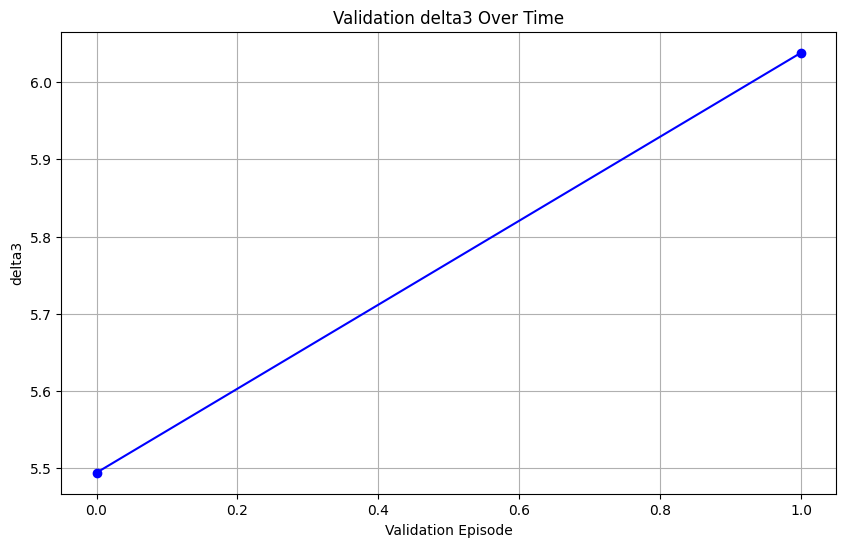

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(delta, marker='o', linestyle='-', color='b')
plt.title('Validation delta3 Over Time')
plt.xlabel('Validation Episode')
plt.ylabel('delta3')
plt.grid(True)
plt.show()

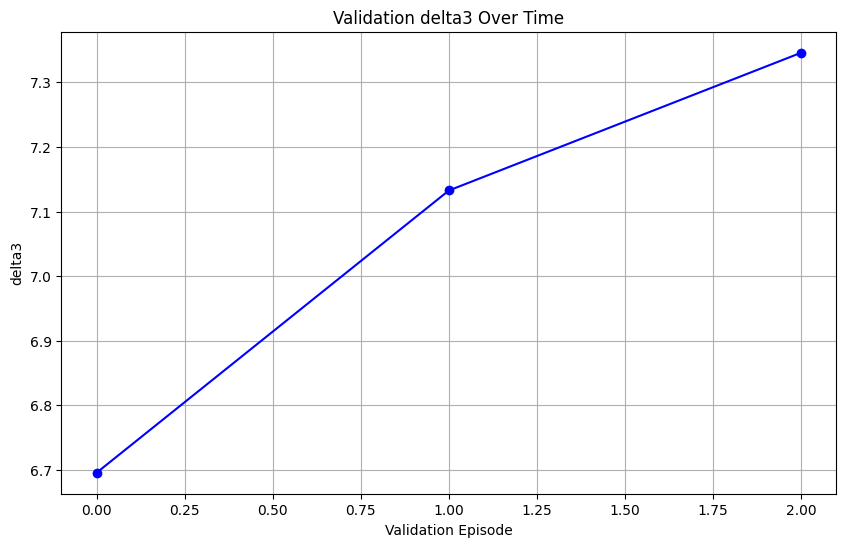

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(delta, marker='o', linestyle='-', color='b')
plt.title('Validation delta3 Over Time')
plt.xlabel('Validation Episode')
plt.ylabel('delta3')
plt.grid(True)
plt.show()

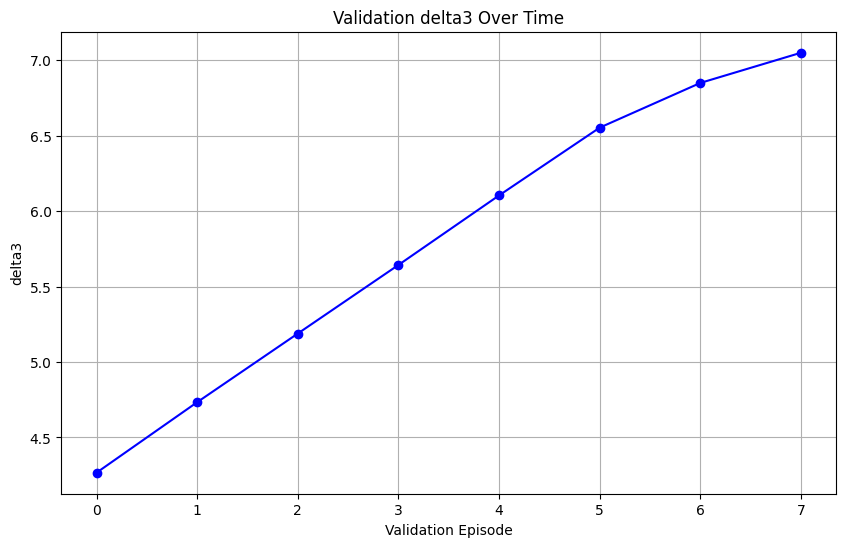

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(delta, marker='o', linestyle='-', color='b')
plt.title('Validation delta3 Over Time')
plt.xlabel('Validation Episode')
plt.ylabel('delta3')
plt.grid(True)
plt.show()

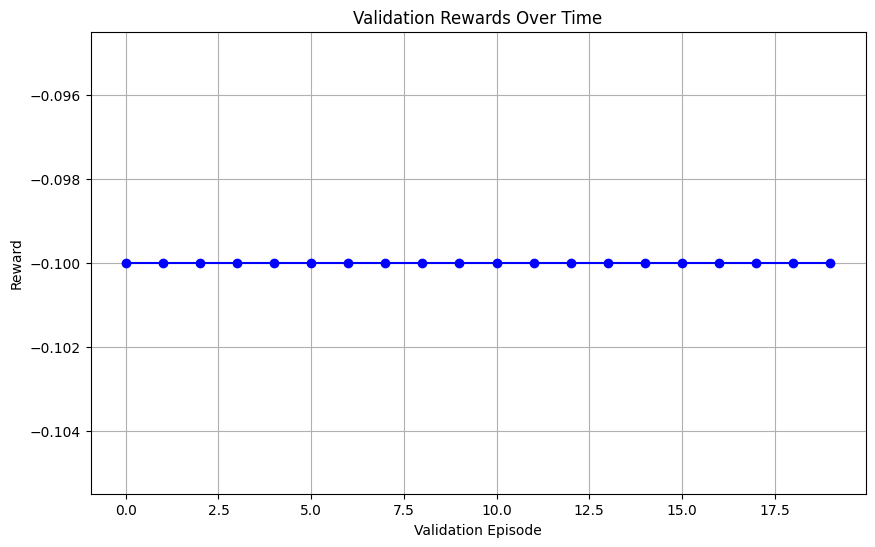

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(validation_rewards, marker='o', linestyle='-', color='b')
plt.title('Validation Rewards Over Time')
plt.xlabel('Validation Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

In [116]:
!pip install gymnasium

81779.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
